In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
sns.set(style='whitegrid',context='notebook')
plt.rcParams['figure.figsize'] = (5, 5)

height has been deprecated.



In [2]:
far_df = pd.read_csv('./datasets/firmannualreports.csv',index_col=0)
ptu_df = pd.read_csv('./datasets/processtechnologyuses.csv',index_col=0)
advisor_df = pd.read_csv('./datasets/advisor.csv',index_col=0)
client_df = pd.read_csv('./datasets/client.csv',index_col=0)
financial_df = pd.read_csv('./datasets/financial.csv',index_col=0)
frb_df = pd.read_csv('./datasets/financialrevenuebreakdown.csv',index_col=0)
foe_df = pd.read_csv('./datasets/financialoperatingexpenses.csv',index_col=0)
fs_df = pd.read_csv('./datasets/firmsection.csv',index_col=0)
owner_df = pd.read_csv('./datasets/owner.csv',index_col=0)
process_df = pd.read_csv('./datasets/process.csv',index_col=0)
rev_df = pd.read_csv('./datasets/revenue.csv',index_col=0)
results_df = pd.read_csv('./datasets/firmanalyticsresults.csv',index_col=0)

In [3]:
df = far_df.merge(fs_df,how='inner',left_on='firmsectionid',right_index=True)
df = df.merge(client_df,how='inner',left_on='clientid',right_index=True)
df = df.merge(rev_df,how='inner',left_on='revenueid',right_index=True)
df = df.merge(process_df.astype('int'),how='inner',left_on='processid',right_index=True)
df = df.merge(ptu_df.astype('int'),how='inner',left_on='processtechnologyuseid',right_index=True)
df = df.merge(financial_df,how='inner',left_on='financialsid',right_index=True)
df = df.merge(advisor_df,how='inner',left_index=True,right_on='firmannualreportid')
df = df.merge(owner_df.astype('float'),how='inner',left_index=True,right_on='firmannualreportid')
df = df.merge(frb_df,how='inner',left_on='RevenueBreakdownId',right_index=True)
df = df.merge(foe_df,how='inner',left_on='OperatingExpensesId',right_index=True)
df = df.merge(results_df,how='inner',left_on='firmanalyticsresultid',right_index=True)
df.head()

,firmannualreportid,year,yearsinbusiness,firmid,firmsectionid,clientid,revenueid,processid,processtechnologyuseid,financialsid,firmanalyticsresultid,employeecount,ClientsCount,AverageClientAge,AverageClientRelationshipLength,AverageClientAdditions,AverageClientDepartures,ReferralRate,InstitutionalAumPercent,TopFiveClientsAumPercent,BeneficiaryLevel,ClientMeetingFrequency,Aum,DiscretionaryInvestmentAumPercent,AverageBasisPointsForAdvisory,NonCompetes,SuccessionPlan,ManagementRetentionProgram,ContinuityPlan,CompensationBonusPlan,StockOwnershipPlan,TechnologyDisasterRecoveryPlan,RecentLegalIssues,CurrentLegalIssues,crm,accounting,portfoliomanagement,portfolioaccounting,financialplanning,firmwebsite,clientportal,socialmedia,email,digitalcompliancemonitoring,digitalfinancialrecords,robotechnology,riskassessmentsoftware,TotalNetRevenue,ProjectedAnnualGrowthRate,RecurringRevenuePercent,TotalOutstandingAssets,TotalOutstandingLiabilities,RevenueBreakdownId,OperatingExpensesId,OtherIncomeAndExpensesId,OperatingExpenseAdjustmentsId,firmannualreportid_x,age_x,yearjoinedfirm_x,firmannualreportid_y,ispassive,isadvisor,age_y,ownershippercent,yearjoinedfirm_y,OtherPercent,EquityPercent,FixedIncomePercent,MutualFundsPercent,MunicipalsPercent,CommoditiesPercent,ManagedMoneyPercent,InsurancePercent,AnnuityPercent,FinancialPlanningAndConsultingPercent,OtherServicesPercent,totaldirectexpense,othercompensationandbenefits,officeexpenses,rent,technology,professionalservices,marketingandbusinessdevelopment,travelandentertainment,insurance,other,depreciation,amortization,taxes,Year,CashflowValue,NetBalanceSheet,TotalValue,NetRevenue,OperatingExpenses,IncomeFromOperations,Ebitda,Eboc,TruelyticsScore,DiscountRate,ComparablesId,GrowthRateId,ExpenseRatioId,DiscountFactorId,BusinessStabilityId,MarketStabilityId,ClientStabilityId,ProFormaId
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,2014,28.0,591,1,1,1,1,1,1,1,14,982,59,11,40,35,100.0,6.0,12.0,0.0,3.0,475000000.0,43.0,0.0,0,1,0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,2350000.0,5.0,87.0,0.0,0.0,1,1,1,1,1,46.0,2008.0,1.0,0.0,1.0,71.0,50.0,1986.0,0.0,0.0,0.0,29.0,0.0,4.0,57.0,0.0,10.0,0.0,0.0,346067.0,8024.0,36925.0,62731.0,105222.0,24657.0,119618.0,43809.0,2187.0,3693.0,0.0,0.0,0.0,2014,7.208358e+06,0.0,7.208358e+06,2350000.0,557000.0,1793000.0,1830000.0,2360000.0,2.944333,30.3,1,1,1,1,1,3,2,1
2,1,2014,28.0,591,1,1,1,1,1,1,1,14,982,59,11,40,35,100.0,6.0,12.0,0.0,3.0,475000000.0,43.0,0.0,0,1,0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,2350000.0,5.0,87.0,0.0,0.0,1,1,1,1,1,46.0,2008.0,1.0,0.0,1.0,69.0,50.0,1998.0,0.0,0.0,0.0,29.0,0.0,4.0,57.0,0.0,10.0,0.0,0.0,346067.0,8024.0,36925.0,62731.0,105222.0,24657.0,119618.0,43809.0,2187.0,3693.0,0.0,0.0,0.0,2014,7.208358e+06,0.0,7.208358e+06,2350000.0,557000.0,1793000.0,1830000.0,2360000.0,2.944333,30.3,1,1,1,1,1,3,2,1
3,2,2014,28.0,591,1,1,1,1,1,1,1,14,982,59,11,40,35,100.0,6.0,12.0,0.0,3.0,475000000.0,43.0,0.0,0,1,0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,2350000.0,5.0,87.0,0.0,0.0,1,1,1,1,1,41.0,2013.0,2.0,0.0,1.0,56.0,100.0,1996.0,0.0,0.0,0.0,29.0,0.0,4.0,57.0,0.0,10.0,0.0,0.0,346067.0,8024.0,36925.0,62731.0,105222.0,24657.0,119618.0,43809.0,2187.0,3693.0,0.0,0.0,0.0,2014,7.208358e+06,0.0,7.208358e+06,2350000.0,557000.0,1793000.0,1830000.0,2360000.0,2.944333,30.3,1,1,1,1,1,3,2,1
6,5,2015,18.0,203,5,5,5,5,5,5,5,7,80,65,15,1,1,90.0,0.0,10.0,0.0,1.0,202020000.0,100.0,0.0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,662674.0,5.0,90.0,0.0,0.0,5,5,5,5,5,44.0,2060.0,5.0,0.0,1.0,78.0,50.0,1985.0,0.0,20.0,20.0,50.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0,140800.0,0.0,13450.0,50000.0,4500.0,0.0,2500.0,25500.0,14078.0,0.0,9197.0,10401.0,24300.0,2015,1.376342e+06,0.0,1.376342e+06,662674.0,392050.0,270624.0,294924.0,473224.0,2.388667,32.5,5,5,5,5,13,15,14,5
7,5,2015,18.0,203,5,5,5,5,5,5,5,7,80,65,15,1,1,90.0,0.0,10.0,0.0,1.0,202020000.0,100.0,0.0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,662674.0,5.0,90.0,0.0,0.0,5,5,5,5,5,44.0

In [4]:
rm_col = ['firmid','firmsectionid','clientid','revenueid','processid','processtechnologyuseid',
          'financialsid','firmanalyticsresultid','firmannualreportid_x','RevenueBreakdownId',
          'OperatingExpensesId','OtherIncomeAndExpensesId','OperatingExpenseAdjustmentsId',
          'firmannualreportid_y','TotalNetRevenue','firmannualreportid','TotalOutstandingAssets',
          'Aum','ProjectedAnnualGrowthRate','RecurringRevenuePercent','TotalOutstandingLiabilities',
          'OtherPercent','ispassive','isadvisor']
df.drop(rm_col,axis=1,inplace=True)

In [5]:
numerical_cols = df.columns[:65]
N = len(numerical_cols)
X = df[numerical_cols].values.reshape(-1,N)
#NetRevenue,OperatingExpenses,Ebitda,Eboc
y = df['Eboc'].values.reshape(-1,1)

#standardize
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

In [6]:
cv = ShuffleSplit(n_splits=20, test_size=0.25, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X_std,y_std, test_size=.2, random_state=42)

R^2 Train: 0.99862, test: 0.99263
MSE Train: 0.00147, test: 0.00541


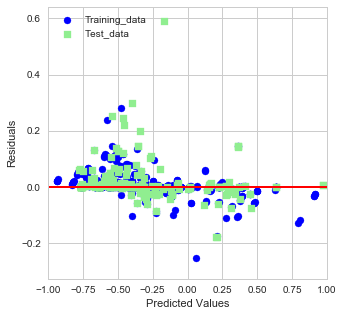

In [7]:
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=42,
                               n_jobs=-1,
                               oob_score=True)
forest.fit(X_train,y_train.reshape(-1))
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('R^2 Train: %.5f, test: %.5f' % (r2_score(y_train,y_train_pred),r2_score(y_test, y_test_pred)))

print('MSE Train: %.5f, test: %.5f' % (mean_squared_error(y_train,y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
plt.scatter(y_train_pred,(y_train_pred.reshape(-1,1)-y_train),c='blue',label='Training_data',marker='o')
plt.scatter(y_test_pred,(y_test_pred.reshape(-1,1)-y_test),c='lightgreen',marker='s',label='Test_data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-1,xmax=1,color='red',lw=2)
plt.xlim([-1,1])
plt.show()

In [8]:
fts = forest.feature_importances_
ft_df = pd.DataFrame([],columns=['type','feature_importance'])
ft_df['type'] = numerical_cols
ft_df['feature_importance'] = fts
ft_df.sort_values('feature_importance',ascending=False)

,type,feature_importance
10,TopFiveClientsAumPercent,0.255652
56,technology,0.147370
61,other,0.074389
59,travelandentertainment,0.072350
60,insurance,0.042582
5,AverageClientRelationshipLength,0.038170
42,EquityPercent,0.035960
53,othercompensationandbenefits,0.032567
50,FinancialPlanningAndConsultingPercent,0.030343
46,CommoditiesPercent,0.021274
